## Imports

In [203]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad
from scipy.stats import pearsonr

## Load data

In [204]:
# Define the data folders.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
fig_folder = (
    "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/visualize/figures/"
)
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"

In [205]:
# Load the data.
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

# Load the MOFA model.
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
mdata.obsm["X_mofa"] = mofa_model.get_factors()

# Load the Mowgli model.
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]

# This is needed somehow.
mdata.uns = {}

In [206]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"
# enrichment_file = "enrichr"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Actually, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

elif enrichment_file == "enrichr": # Get enrichr results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichr.csv", index_col=0)
    enr.rename(columns={"path_name": "native", "adj_p_val": "p_value"}, inplace=True)

enr["name"] = enr["native"]
enr = enr[enr["p_value"] < .05]
enr["minlogp"] = -np.log10(enr["p_value"])

In [207]:
idx_MF = enr["source"] == "GO_Molecular_Function_2021" # Molecular function
idx_CC = enr["source"] == "GO_Cellular_Component_2021" # Cellular component
idx_BP = enr["source"] == "GO_Biological_Process_2021" # Biological process
idx_KEGG = enr["source"] == "KEGG_2021_Human" # KEGG pathways
idx_Reac = enr["source"] == "Reactome_2016" # Reactome pathways
idx_Marker = enr["source"] == "CellMarker_Augmented_2021" # Cell types

## Annotate Mowgli

In [208]:
# Make an object for the Mowgli embedding.
mowgli_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)
mowgli_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

# Compute neighbors for Mowgli.
sc.pp.neighbors(mowgli_embedding, n_neighbors=25)

# Compute UMAP for Mowgli
sc.tl.umap(mowgli_embedding)

# Compute Leiden for Mowgli
sc.tl.leiden(mowgli_embedding, resolution=0.2, key_added="leiden")

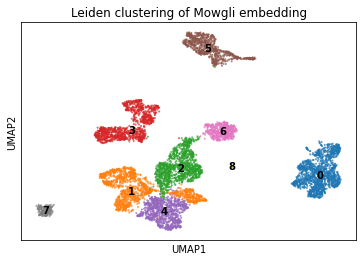

In [209]:
sc.pl.umap(mowgli_embedding, color="leiden", alpha=0.7, legend_loc="on data", title="Leiden clustering of Mowgli embedding")

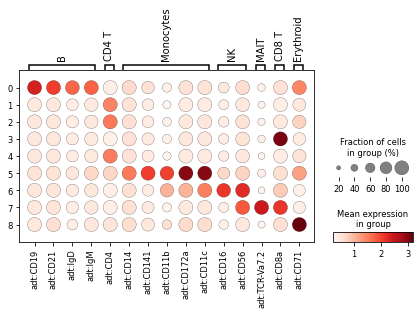

In [210]:
sc.pl.dotplot(
    mowgli_embedding,
    {
        "B": ["adt:CD19", "adt:CD21", "adt:IgD", "adt:IgM"],
        "CD4 T": "adt:CD4",
        "Monocytes": ["adt:CD14", "adt:CD141", "adt:CD11b", "adt:CD172a", "adt:CD11c"],
        "NK": ["adt:CD16", "adt:CD56"],
        "MAIT": "adt:TCR-Va7.2",
        "CD8 T": "adt:CD8a",
        "Erythroid": "adt:CD71",
    },
    groupby="leiden",
    expression_cutoff=1e-3,
)


In [211]:
# Annotate the Mowgli embedding.
cluster_names = {
    0: "B cells",
    1: "CD4 T cells",
    2: "CD4 T cells",
    3: "CD8 T cells",
    4: "CD4 T cells",
    5: "Monocytes",
    6: "NK cells",
    7: "MAIT T cells",
    8: "Erythroid cells",
}
mowgli_embedding.obs["leiden"] = [
    cluster_names[c] for c in mowgli_embedding.obs["leiden"].cat.codes
]

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


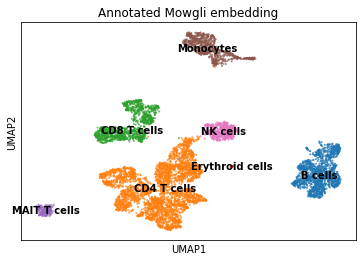

In [212]:
sc.pl.umap(mowgli_embedding, color="leiden", alpha=0.7, legend_loc="on data", title="Annotated Mowgli embedding")

## Interpret Mowgli's dimensions

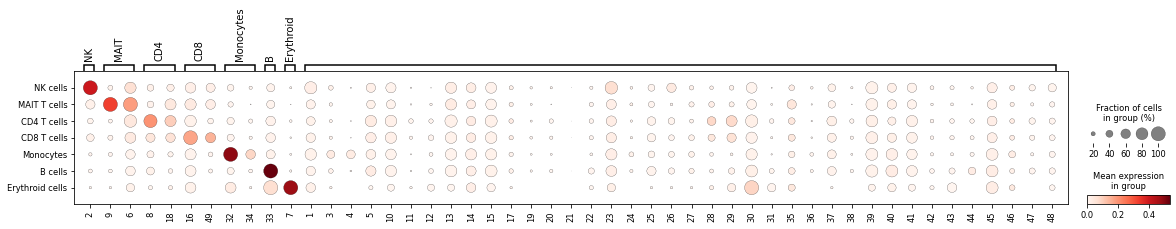

In [213]:
varnames = {
    "NK": ["2"],
    "MAIT": ["9", "6"],
    "CD4": ["8", "18"],
    "CD8": ["16", "49"],
    "Monocytes": ["32", "34"],
    "B": ["33"],
    "Erythroid": ["7"],
    " ": ["1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48"],
}
sc.pl.dotplot(
    mowgli_embedding,
    varnames,
    groupby="leiden",
    categories_order=[
        "NK cells",
        "MAIT T cells",
        "CD4 T cells",
        "CD8 T cells",
        "Monocytes",
        "B cells",
        "Erythroid cells",
    ],
    expression_cutoff=1e-4,
)


In [214]:
celltypes = [
    "Natural Killer CL0000623",
    "B Cell CL0000785",
    "Monocyte CL0000576",
    "CD4 T CL0000624",
    "CD8 T CL0000625",
    "Mucosal Associated Invariant T CL0000940",
]


In [215]:
mowgli_pvals = ad.AnnData(np.zeros((len(celltypes), mowgli_embedding.n_vars)))
mowgli_pvals.obs_names = celltypes
mowgli_pvals.var_names = mowgli_embedding.var_names

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["method"] == "mowgli"
    mowgli_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mowgli_pvals.obs["celltype"] = pd.Categorical(mowgli_pvals.obs_names)

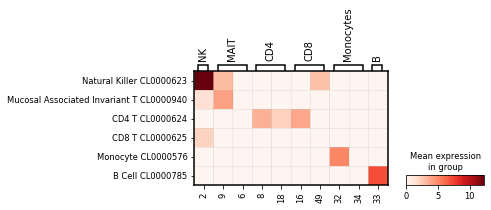

In [216]:
varnames = {
    "NK": ["2"],
    "MAIT": ["9", "6"],
    "CD4": ["8", "18"],
    "CD8": ["16", "49"],
    "Monocytes": ["32", "34"],
    "B": ["33"],
    # "Erythroid": ["7"],
    # " ": ["1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48"],
}
sc.pl.matrixplot(mowgli_pvals, varnames, groupby="celltype", categories_order=[
    "Natural Killer CL0000623",
    "Mucosal Associated Invariant T CL0000940",
    "CD4 T CL0000624",
    "CD8 T CL0000625",
    "Monocyte CL0000576",
    "B Cell CL0000785",
], cmap="Reds")

In [217]:
# Pearson correlation.

idx = [2, 9, 6, 8, 18, 16, 49, 32, 34, 33, 7]

pval_matrix = mowgli_pvals[
    [
        "B Cell CL0000785",
        "Monocyte CL0000576",
        "Natural Killer CL0000623",
        "Mucosal Associated Invariant T CL0000940",
        "CD4 T CL0000624",
        "CD8 T CL0000625",
    ]
].X[:, idx]


mean_dim_matrix = np.vstack(
    [
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "B cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "Monocytes"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "NK cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "MAIT T cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "CD4 T cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "CD8 T cells"].X.mean(0),
    ]
)[:, idx]

pearsonr(pval_matrix.ravel(), mean_dim_matrix.ravel())[0]


0.7765665356268275

## Annotate MOFA

In [218]:
# Make an object for the MOFA embedding.
mofa_embedding = ad.AnnData(mdata.obsm["X_mofa"], obs=mdata.obs)
mofa_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

# Compute neighbors for MOFA.
sc.pp.neighbors(mofa_embedding, n_neighbors=25)

# Compute UMAP for MOFA.
sc.tl.umap(mofa_embedding)

# Compute Leiden for MOFA.
sc.tl.leiden(mofa_embedding, resolution=0.2, key_added="leiden")

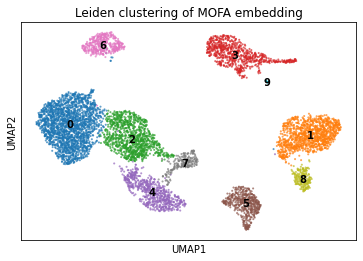

In [219]:
sc.pl.umap(mofa_embedding, color="leiden", alpha=0.7, legend_loc="on data", title="Leiden clustering of MOFA embedding")

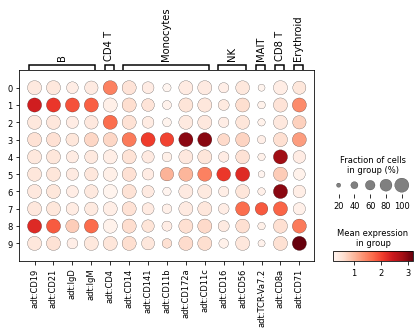

In [220]:
sc.pl.dotplot(
    mofa_embedding,
    {
        "B": ["adt:CD19", "adt:CD21", "adt:IgD", "adt:IgM"],
        "CD4 T": "adt:CD4",
        "Monocytes": ["adt:CD14", "adt:CD141", "adt:CD11b", "adt:CD172a", "adt:CD11c"],
        "NK": ["adt:CD16", "adt:CD56"],
        "MAIT": "adt:TCR-Va7.2",
        "CD8 T": "adt:CD8a",
        "Erythroid": "adt:CD71",
    },
    groupby="leiden",
    expression_cutoff=1e-3,
)


In [221]:
# Annotate the MOFA emebdding.
cluster_names = {
    1: "B cells",
    8: "B cells",
    0: "CD4 T cells",
    2: "CD4 T cells",
    4: "CD8 T cells",
    6: "CD8 T cells",
    3: "Monocytes",
    5: "NK cells",
    7: "MAIT T cells",
    9: "Erythroid cells",
}
mofa_embedding.obs["leiden"] = [
    cluster_names[c] for c in mofa_embedding.obs["leiden"].cat.codes
]

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


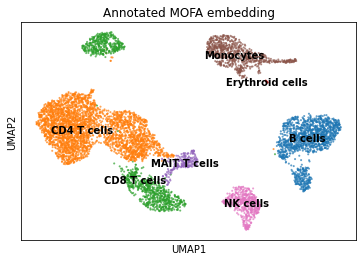

In [222]:
sc.pl.umap(mofa_embedding, color="leiden", alpha=0.7, legend_loc="on data", title="Annotated MOFA embedding")

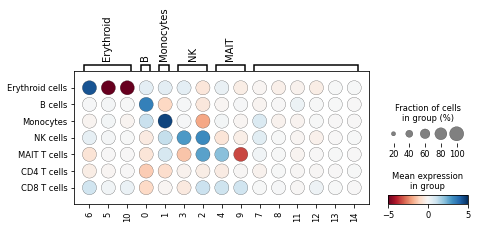

In [223]:
varnames = {
    "Erythroid": ["6", "5", "10"],
    "B": ["0"],
    "Monocytes": ["1"],
    "NK": ["3", "2"],
    "MAIT": ["4", "9"],
    " ": ["7", "8", "11", "12", "13", "14"],
}
sc.pl.dotplot(
    mofa_embedding,
    varnames,
    groupby="leiden",
    categories_order=[
        "Erythroid cells",
        "B cells",
        "Monocytes",
        "NK cells",
        "MAIT T cells",
        "CD4 T cells",
        "CD8 T cells",
    ],
    expression_cutoff=-100,
    vmin=-5,
    vmax=5,
    cmap="RdBu",
)


In [224]:
celltypes = [
    "Natural Killer CL0000623",
    "B Cell CL0000785",
    "Monocyte CL0000576",
    "CD4 T CL0000624",
    "CD8 T CL0000625",
    "Mucosal Associated Invariant T CL0000940",
]


In [225]:
mofa_pvals = ad.AnnData(np.zeros((len(celltypes), mofa_embedding.n_vars)))
mofa_pvals.obs_names = celltypes
mofa_pvals.var_names = mofa_embedding.var_names

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["query"].str.startswith("top_mofa")
    mofa_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]

    idx = enr["native"] == celltype
    idx &= enr["query"].str.startswith("bottom_mofa")
    mofa_pvals.X[i, enr.loc[idx, "dim"]] = -enr.loc[idx, "minlogp"]
mofa_pvals.obs["celltype"] = pd.Categorical(mofa_pvals.obs_names)

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


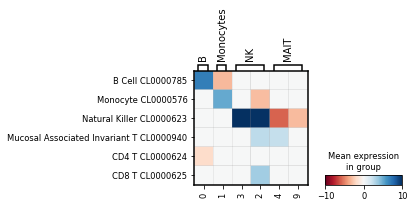

In [226]:
varnames = {
    # "Erythroid": ["6", "5", "10"],
    "B": ["0"],
    "Monocytes": ["1"],
    "NK": ["3", "2"],
    "MAIT": ["4", "9"],
    # " ": ["7", "8", "11", "12", "13", "14"],
}
sc.pl.matrixplot(mofa_pvals, varnames, groupby="celltype", categories_order=[
    "B Cell CL0000785",
    "Monocyte CL0000576",
    "Natural Killer CL0000623",
    "Mucosal Associated Invariant T CL0000940",
    "CD4 T CL0000624",
    "CD8 T CL0000625",
], vmin=-10, vmax=10, cmap="RdBu")

In [227]:
# Pearson correlation.

idx = [6, 5, 10, 0, 1, 3, 2, 4, 9]
pval_matrix = mofa_pvals[
    [
        "B Cell CL0000785",
        "Monocyte CL0000576",
        "Natural Killer CL0000623",
        "Mucosal Associated Invariant T CL0000940",
        "CD4 T CL0000624",
        "CD8 T CL0000625",
    ]
].X[:, idx]


mean_dim_matrix = np.vstack(
    [
        mofa_embedding[mofa_embedding.obs["leiden"] == "B cells"].X.mean(0),
        mofa_embedding[mofa_embedding.obs["leiden"] == "Monocytes"].X.mean(0),
        mofa_embedding[mofa_embedding.obs["leiden"] == "NK cells"].X.mean(0),
        mofa_embedding[mofa_embedding.obs["leiden"] == "MAIT T cells"].X.mean(0),
        mofa_embedding[mofa_embedding.obs["leiden"] == "CD4 T cells"].X.mean(0),
        mofa_embedding[mofa_embedding.obs["leiden"] == "CD8 T cells"].X.mean(0),
    ]
)[:, idx]

pearsonr(pval_matrix.ravel(), mean_dim_matrix.ravel())[0]


0.703919448902652